# **Context Encoders**


## Load libraries, models

In [1]:
import numpy as np
from utils.load_dataset import get_all_datasets
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
from model import ContextEncoder, Discriminator
from classifier import create_wildfire_classifier
from utils.utils_gan import get_mask, apply_mask, train_one_epoch, load_checkpoint, plot_comparison

In [2]:
def extract_masked(true, pred, mask):
    pred = pred.detach().cpu().numpy()
    zone_true = np.zeros((50,50,3))
    zone_pred = np.zeros((50,50,3))
    for i in range(3):
        zone_true[:,:,i] = true[0,i,...].flatten()[np.flatnonzero(1-mask[0,0])].reshape((50,50))
        zone_pred[:,:,i] = pred[0,i,...].flatten()[np.flatnonzero(1-mask[0,0])].reshape((50,50))

    return zone_true, zone_pred

## Load data

In [3]:
dataset_path = Path('../data')
pretrain_path = dataset_path / 'train'
val_path = dataset_path / 'valid'
test_path = dataset_path / 'test'
data_transforms = {
    'pretrain': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ]),
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pretrain_dataset, train_dataset, val_dataset, test_dataset = get_all_datasets(pretrain_path=pretrain_path,
                                                                              val_path=val_path,
                                                                              test_path=test_path,
                                                                              transforms_dict=data_transforms)

## Load model

In [4]:
pretrain_dataloader = DataLoader(pretrain_dataset, batch_size=16)
model = ContextEncoder()
discriminator = Discriminator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path_check = '../checkpoints/context_encoder/context_encoder.pt'
load_checkpoint(path_check, model, discriminator)

/home/enzolouv/Documents/ENS PS 2024-2025/cours/computer_vision/project_wildfire/context_encoder/utils/utils_gan.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkp

## Visualize ContextEncoder performances

In [5]:
def plot_grid_pair_comparisons(true_images, pred_images, title="Sample Reconstructions"):
  """
  Plots 9 (3x6) subplots where each true image and its prediction are shown separately.
  
  Parameters:
  - true_images: list of numpy arrays for true images.
  - pred_images: list of numpy arrays for predicted images.
  - title: overall title for the figure.
  
  Returns:
  - The matplotlib figure.
  """
  fig, axes = plt.subplots(2, 4, figsize=(18, 9))
  fig.suptitle(title, fontsize=16)
  
  # Loop through each pair and assign them to two consecutive subplots.
  for idx in range(len(true_images)):
    row = idx // 2  # three pairs per row
    col_true = (idx % 2) * 2      # true image in even column
    col_pred = (idx % 2) * 2 + 1  # predicted image in next column
    
    axes[row, col_true].imshow(true_images[idx])
    axes[row, col_true].set_xticks([])
    axes[row, col_true].set_yticks([])
    
    axes[row, col_pred].imshow(pred_images[idx])
    axes[row, col_pred].axis("off")
    axes[row, col_pred].set_xticks([])
    axes[row, col_pred].set_yticks([])
  
  plt.tight_layout()
  plt.subplots_adjust(top=0.90)
  return fig


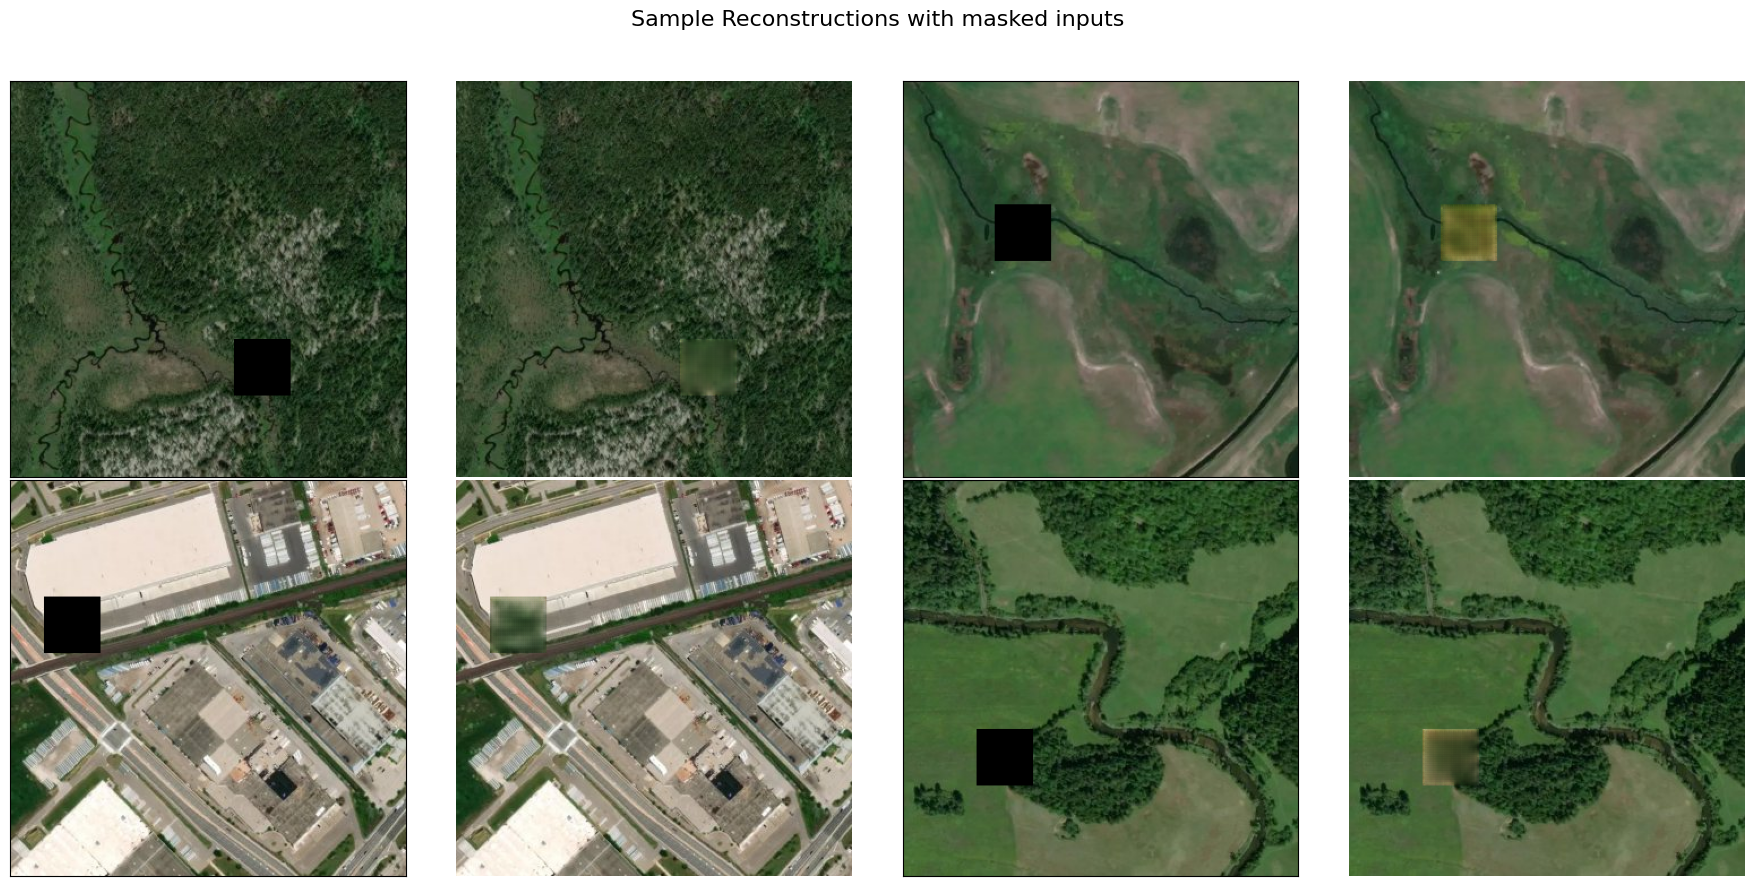

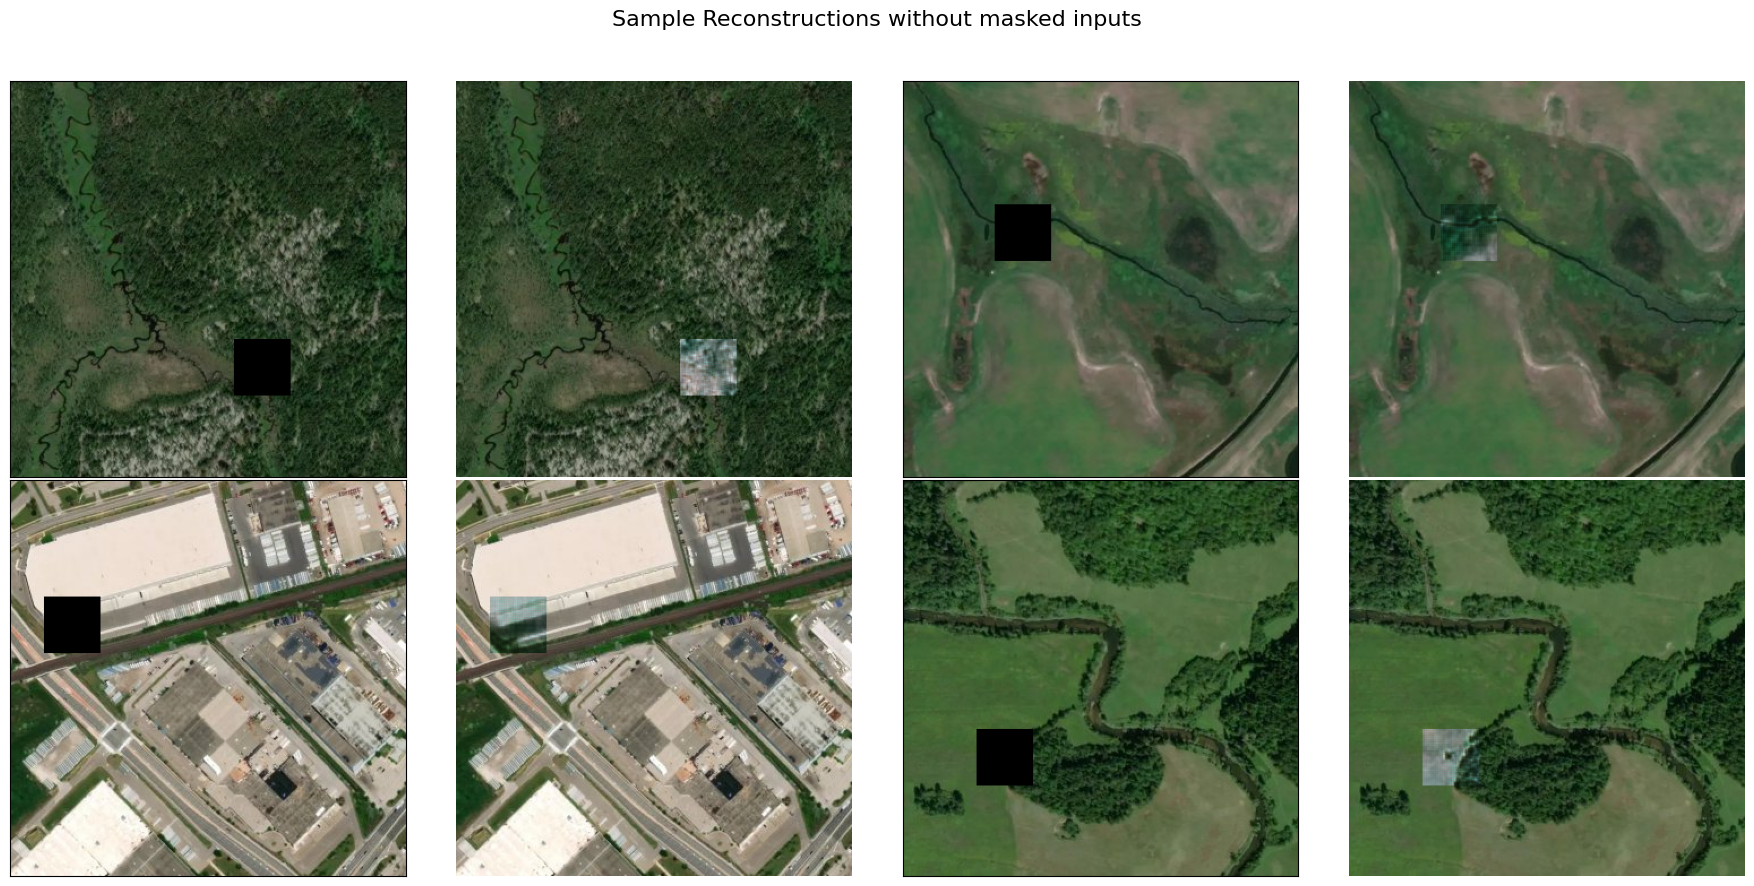

/tmp/ipykernel_153794/899949498.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  zone_true[:,:,i] = true[0,i,...].flatten()[np.flatnonzero(1-mask[0,0])].reshape((50,50))


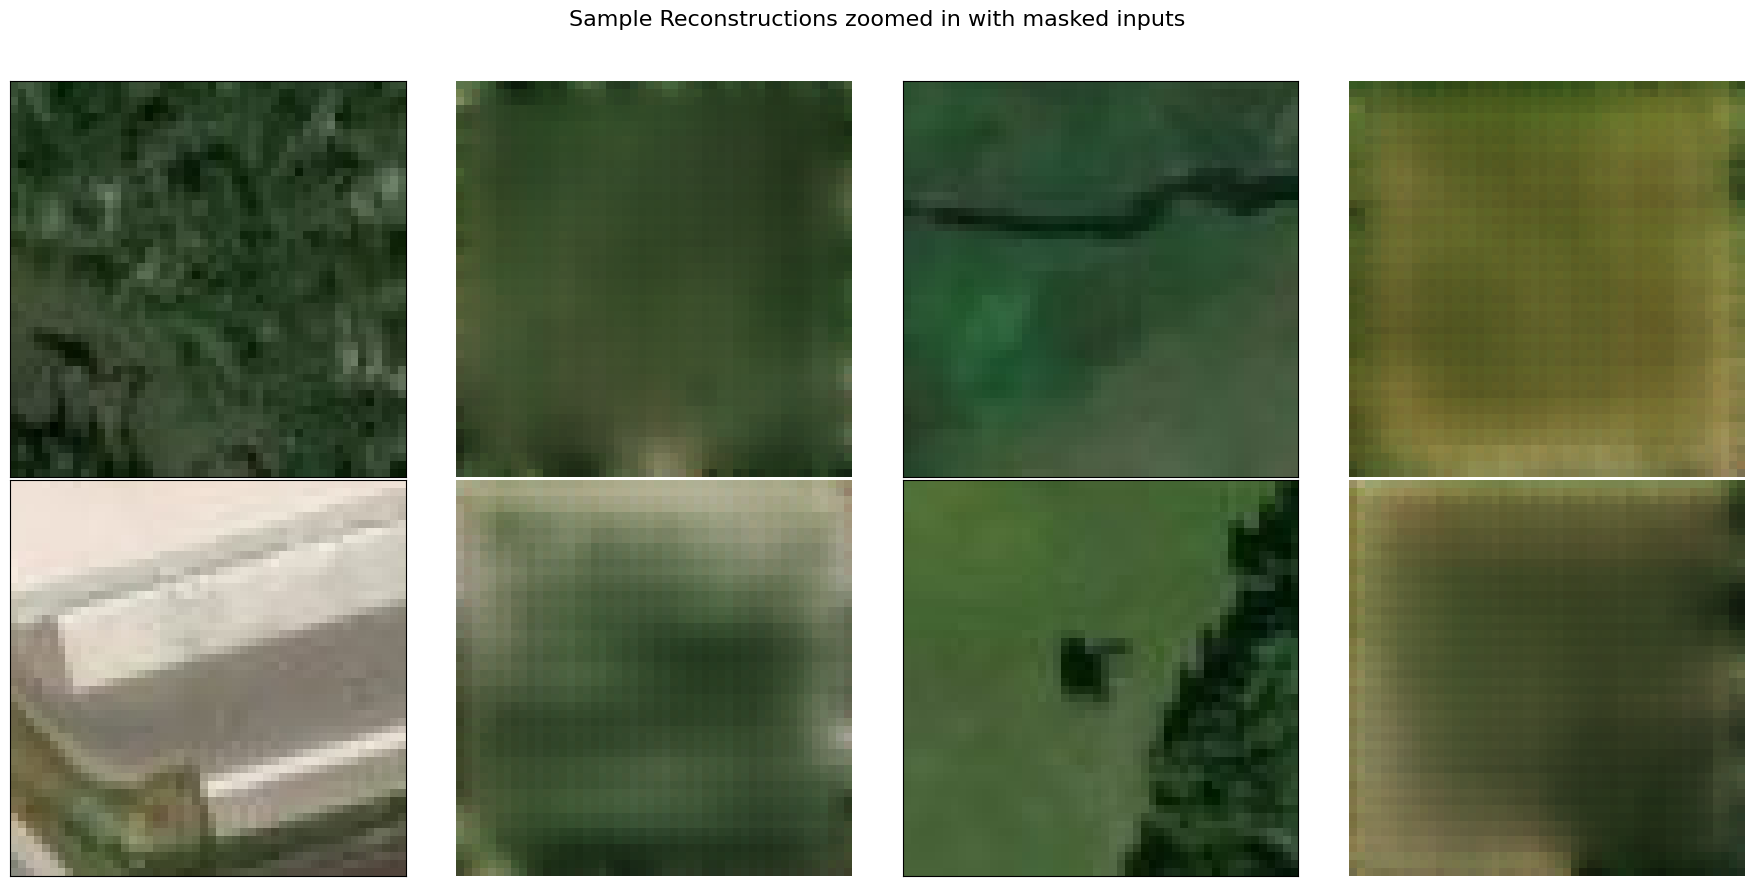

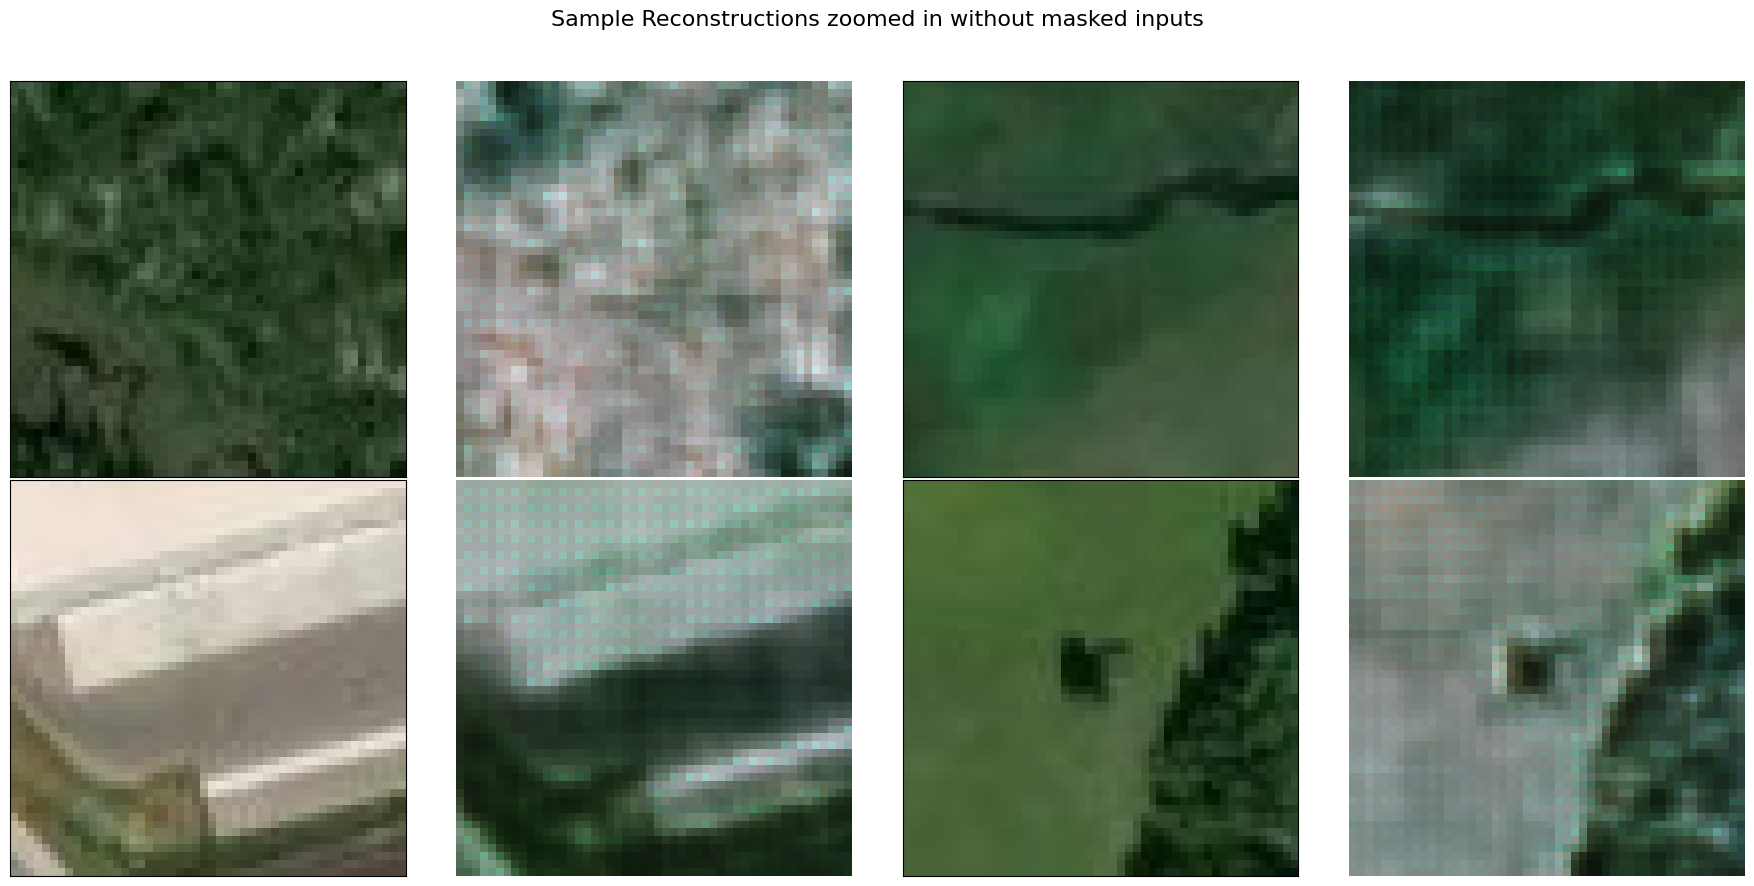

In [8]:
ds = train_dataset
true_images = []
pred_images = []
ids = []
masks = []
n = 4
path = '/home/enzolouv/Documents/ENS PS 2024-2025/cours/computer_vision/project_wildfire/outputs/context_encoder'
for i in range(n):
    idx = np.random.randint(0,len(ds))
    ids.append(idx)
    true = ds[idx][0][None]
    mask = get_mask(true.shape)
    masks.append(mask)
    input_masked, output_masked_gt = apply_mask(true, mask)
    pred = model(input_masked)
    reconstructed = pred*(1-mask) + true*mask
    true_images.append(input_masked[0].permute(1,2,0).detach().cpu().numpy())
    pred_images.append(reconstructed[0].permute(1,2,0).detach().cpu().numpy())
fig = plot_grid_pair_comparisons(true_images, pred_images, "Sample Reconstructions with masked inputs")
plt.savefig(f'{path}/reconstructions_masked.png')
plt.show()

true_images = []
pred_images = []

for i in range(n):
    idx = ids[i]
    true = ds[idx][0][None]
    mask = masks[i]
    input_masked, output_masked_gt = apply_mask(true, mask)
    pred = model(true)
    reconstructed = pred*(1-mask) + true*mask
    true_images.append(input_masked[0].permute(1,2,0).detach().cpu().numpy())
    pred_images.append(reconstructed[0].permute(1,2,0).detach().cpu().numpy())
fig = plot_grid_pair_comparisons(true_images, pred_images, "Sample Reconstructions without masked inputs")
plt.savefig(f'{path}/reconstructions.png')
plt.show()


true_images = []
pred_images = []
for i in range(n):
    idx = ids[i]
    true = ds[idx][0][None]
    mask = masks[i]
    input_masked, output_masked_gt = apply_mask(true, mask)
    pred = model(input_masked)
    reconstructed = pred*(1-mask) + true*mask
    zone_true, zone_pred = extract_masked(true,reconstructed, mask)
    true_images.append(zone_true)
    pred_images.append(zone_pred)
fig = plot_grid_pair_comparisons(true_images, pred_images, "Sample Reconstructions zoomed in with masked inputs")
plt.savefig(f'{path}/reconstructions_masked_zoomed.png')
plt.show()

true_images = []
pred_images = []
for i in range(n):
    idx = ids[i]
    true = ds[idx][0][None]
    mask = masks[i]
    input_masked, output_masked_gt = apply_mask(true, mask)
    pred = model(true)
    reconstructed = pred*(1-mask) + true*mask
    zone_true, zone_pred = extract_masked(true,reconstructed, mask)
    true_images.append(zone_true)
    pred_images.append(zone_pred)
fig = plot_grid_pair_comparisons(true_images, pred_images, "Sample Reconstructions zoomed in without masked inputs")
plt.savefig(f'{path}/reconstructions_zoomed.png')
plt.show()
